# Taking Root - Data Analyst Exercise
###### By Miguel Madriz
##### One challenge we face with quantifying carbon is when our client’s staff go out and trace farms, they sometimes have overlapping areas. These overlaps can be due to GPS errors if they’re small, or they could just be unclear farm boundaries.
The primary issue here is that we always want to avoid “double-counting” carbon. Our field survey carbon estimates currently are based on sampling part of a farm and extrapolation based on the proportion sampled. So if there is an overlap, that area would count twice with our current methods. Double-counting leads to overestimation of carbon, which leads to inaccuracies and can jeopardize our credibility in the market. There are other operational issues that overlaps cause as well, as they could lead to staff collecting data inefficiently.

#### EDA 
* Load 
* Clean Row Duplicates
* Shapely geometry objects
* Pivot Data Frame (since the source file had 2 columns of Geo)

#### Enrich Data 
* Add Area Measure
* Clean Outliers
* Tag Duplicated Polygons

#### Processing
* Adding new Data Frame to relate Poligons with Overlap
* Add Calculations in details
* Aggregate the information in main data frame
* Show some Charts
* Compute Key Metrics
* Export File for deeper Dashboards


### *Final Dashboard will be pressented in Tableau*
===================================================================

## Load + Preparation

### Installs Requirements

In [26]:
pip install pandas geopandas shapely pyproj


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load file from Github

In [1]:
from shapely.geometry import Polygon
from pyproj import Proj, transform
from shapely import wkt
import geopandas as gpd
import pandas as pd

# Load the CSV file as a pandas DataFrame
url = 'https://raw.githubusercontent.com/farm-trace/taking-root-da-hw/main/data/sample-data.csv'
df = pd.read_csv(url)#, delimiter=',', header=None, names=['ID', 'Pair_a', 'Pair_b'])

### Drop Duplicates Rows

In [2]:
# check for duplicates
has_duplicates = df.duplicated().any()

if has_duplicates:
    df.info()
    df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    print("Dropped duplicated rows?\n")
else:
    print("No duplicates rows\n")
df.info()

No duplicates rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      513 non-null    int64 
 1   Pair_a  513 non-null    object
 2   Pair_b  513 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.1+ KB


### Create new Shapely geometry objects

In [3]:
# Convert the 'POLYGON' column to a Shapely geometry object
df['Geo_a'] = df['Pair_a'].apply(wkt.loads)
df['Geo_b'] = df['Pair_b'].apply(wkt.loads)

df.head()

,id,Pair_a,Pair_b,Geo_a,Geo_b
0,0,"POLYGON ((30.9195000615594 1.22320399310169, 3...","POLYGON ((30.9178628236499 1.22298964247023, 3...","POLYGON ((30.9195000615594 1.22320399310169, 3...","POLYGON ((30.9178628236499 1.22298964247023, 3..."
1,1,"POLYGON ((30.9154907 1.2168457697, 30.91549089...","POLYGON ((30.9176490186294 1.21758566108396, 3...","POLYGON ((30.9154907 1.2168457697, 30.91549089...","POLYGON ((30.9176490186294 1.21758566108396, 3..."
2,2,"POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((31.7216862920056 1.83134403943523, 3..."
3,3,"POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((31.7023455560315 1.83796156365404, 3..."
4,4,"POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((31.7061141722958 1.83877089201203, 3..."


### Pivot and Convert to a GeoDataFrame
Pairs A and B all in just one long list clasified by Type (a/b)

In [4]:
# Define the source coordinate system
src_crs = 'EPSG:4326'

gdf = pd.melt(df, id_vars='id', value_vars=['Pair_a', 'Pair_b'], value_name='Pair')
gdf['Type'] = gdf['variable'].apply(lambda x: x.split('_')[-1])
gdf = gdf.drop('variable', axis=1)
gdf['Geo'] = gdf['Pair'].apply(wkt.loads)
gdf = gdf[['id', 'Type', 'Pair', 'Geo']]
gdf = gdf.rename(columns={'id': 'Id'})

#Build GeoDataFrame keeping Source Cardinal Reference System as EPSG:4326
gdf = gpd.GeoDataFrame(gdf, geometry='Geo', crs=src_crs)
gdf.head(-20)

,Id,Type,Pair,Geo
0,0,a,"POLYGON ((30.9195000615594 1.22320399310169, 3...","POLYGON ((30.91950 1.22320, 30.91951 1.22320, ..."
1,1,a,"POLYGON ((30.9154907 1.2168457697, 30.91549089...","POLYGON ((30.91549 1.21685, 30.91549 1.21685, ..."
2,2,a,"POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((31.72169 1.83134, 31.72168 1.83135, ..."
3,3,a,"POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((31.70235 1.83796, 31.70235 1.83796, ..."
4,4,a,"POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((31.70611 1.83877, 31.70611 1.83877, ..."
...,...,...,...,...
1001,498,b,"POLYGON ((31.7586490977407 1.7777155900218, 31...","POLYGON ((31.75865 1.77772, 31.75865 1.77772, ..."
1002,499,b,"POLYGON ((31.7586490977407 1.7777155900218, 31...","POLYGON ((31.75865 1.77772, 31.75865 1.77772, ..."
1003,500,b,"POLYGON ((31.7651154223458 1.78038090783713, 3...","POLYGON ((31.76512 1.78038, 31.76512 1.78038, ..."
1004,501,b,"POLYGON ((31.7651154223458 1.78038090783713, 3...","POLYGON ((31.76512 1.78038, 31.76512 1.78038, ..."


## Data Enrichment

### Enrich Step 1 - Add Area Measure

In [5]:
# Define the target projected coordinate system
tgt_crs = 'EPSG:3857'
gdf = gdf.to_crs(tgt_crs)
# Add Area column
gdf['Area'] = gdf['Geo'].area
gdf.head(-20)

,Id,Type,Pair,Geo,Area
0,0,a,"POLYGON ((30.9195000615594 1.22320399310169, 3...","POLYGON ((3441943.002 136176.790, 3441943.590 ...",10535.488766
1,1,a,"POLYGON ((30.9154907 1.2168457697, 30.91549089...","POLYGON ((3441496.682 135468.836, 3441496.704 ...",5820.865280
2,2,a,"POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((3531241.965 203899.007, 3531241.536 ...",10608.993490
3,3,a,"POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((3529088.964 204636.044, 3529088.956 ...",6509.284802
4,4,a,"POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((3529508.485 204726.185, 3529507.913 ...",5750.678495
...,...,...,...,...,...
1001,498,b,"POLYGON ((31.7586490977407 1.7777155900218, 31...","POLYGON ((3535356.646 197926.153, 3535356.569 ...",11644.632641
1002,499,b,"POLYGON ((31.7586490977407 1.7777155900218, 31...","POLYGON ((3535356.646 197926.153, 3535356.569 ...",11644.632641
1003,500,b,"POLYGON ((31.7651154223458 1.78038090783713, 3...","POLYGON ((3536076.474 198222.998, 3536077.501 ...",13355.333365
1004,501,b,"POLYGON ((31.7651154223458 1.78038090783713, 3...","POLYGON ((3536076.474 198222.998, 3536077.501 ...",13355.333365


#### Check Area Outliers

No handles with labels found to put in legend.


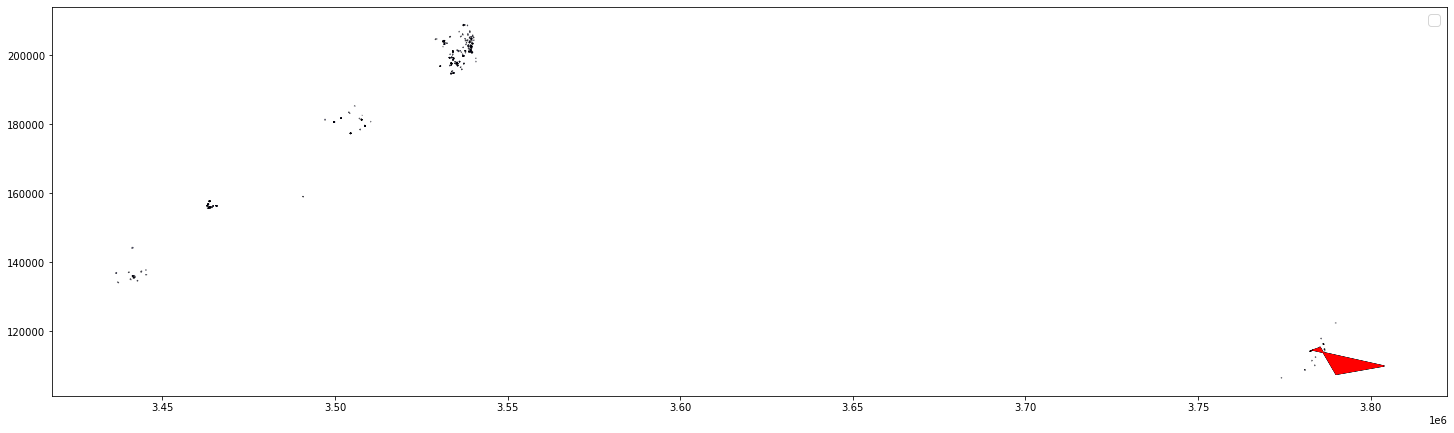

In [6]:
from scipy import stats
import matplotlib.pyplot as plt

# Compute the z-score for the 'Area' column
z_scores = stats.zscore(gdf['Area'])

# Get the absolute z-scores that are greater than 3
abs_z_scores = abs(z_scores)
outliers = gdf[abs_z_scores > 3]

# Plot the data points and outliers
fig, ax = plt.subplots(figsize=(25, 20))
gdf.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black')
if len(outliers) > 0:
    outliers.plot(ax=ax, marker='o', color='red', markersize=50, label='Type')
    plt.legend(prop={'size': 15})
plt.show()
# Save the figure to a file
fig.savefig('/Users/mmadriz/Downloads/taking-root-da-hw-main/images/outliers1.png')

#### Remove Outliers

In [7]:
from scipy import stats

# Compute the z-score for the 'Area' column
z_scores = stats.zscore(gdf['Area'])

# Get the absolute z-scores that are greater than 3
abs_z_scores = abs(z_scores)
outliers = abs_z_scores > 3

# Drop the outliers from the GeoDataFrame
gdf = gdf.drop(gdf[outliers].index)


#### Check Area Without Outliers

No handles with labels found to put in legend.


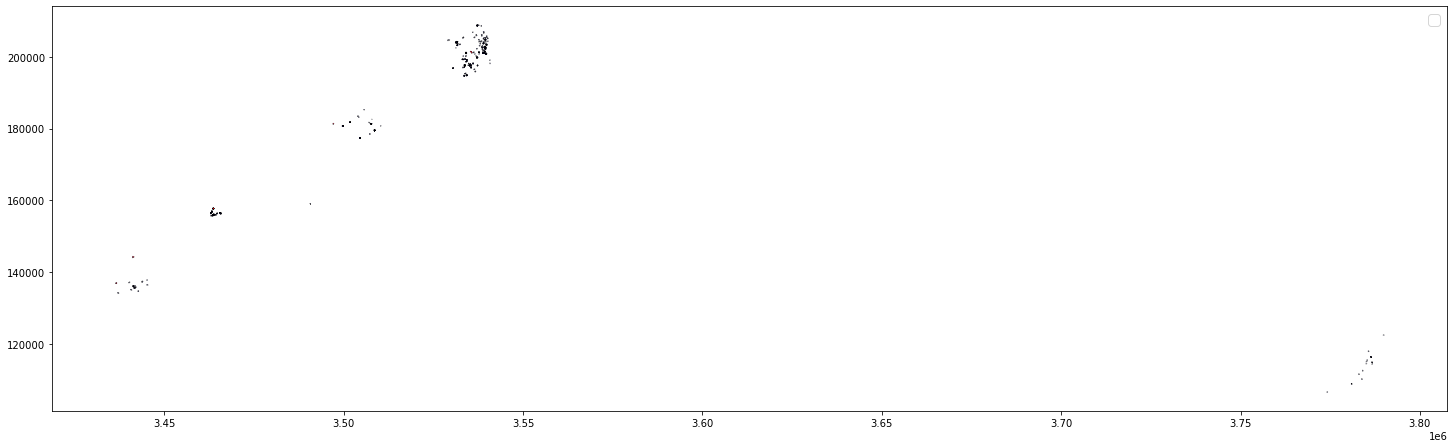

In [8]:
from scipy import stats
import matplotlib.pyplot as plt

# Compute the z-score for the 'Area' column
z_scores = stats.zscore(gdf['Area'])

# Get the absolute z-scores that are greater than 3
abs_z_scores = abs(z_scores)
outliers = gdf[abs_z_scores > 3]

# Plot the data points and outliers
fig, ax = plt.subplots(figsize=(25, 20))
gdf.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black')
if len(outliers) > 0:
    outliers.plot(ax=ax, marker='o', color='red', markersize=50, label='Type')
    plt.legend(prop={'size': 15})
plt.show()
# Save the figure to a file
fig.savefig('/Users/mmadriz/Downloads/taking-root-da-hw-main/images/outliers2.png')

### Enrich Step 2 -  Identify Duplicates Polygons (Tagging Count of Hash)

In [9]:
gdf['Geo_Hash'] = gdf['Geo'].apply(lambda x: hash(x.wkt))
# Add a new column 'Geo_hash_count' by using the groupby() function and the transform() function
gdf['Hash_count'] = gdf.groupby('Geo_Hash')['Geo_Hash'].transform('count')
(gdf[gdf['Hash_count'] == 1].sort_values('Geo_Hash')).head(20)

,Id,Type,Pair,Geo,Area,Geo_Hash,Hash_count
40,40,a,"POLYGON ((34.0163424609166 1.03133768969901, 3...","POLYGON ((3786681.921 114814.187, 3786681.079 ...",3308.873711,-9203253519053920961,1
852,349,b,"POLYGON ((31.7974404169355 1.80609701609516, 3...","POLYGON ((3539674.876 201087.105, 3539675.270 ...",3247.953861,-9182272255558951481,1
879,376,b,"POLYGON ((31.7388605091 1.769838074, 31.738860...","POLYGON ((3533153.790 197048.812, 3533153.799 ...",11330.952215,-8731022404320826705,1
604,93,b,"POLYGON ((33.9041225365112 0.957446916603527, ...","POLYGON ((3774189.657 106587.464, 3774189.663 ...",12045.346436,-8518699054039443463,1
95,97,a,"POLYGON ((34.0002499148761 1.02845035781779, 3...","POLYGON ((3784890.507 114492.719, 3784890.512 ...",1980.354250,-8264631827378137516,1
144,146,a,"POLYGON ((30.9209440112751 1.220141008254, 30....","POLYGON ((3442103.742 135835.743, 3442103.544 ...",2785.916608,-7934055526767959228,1
229,239,a,"POLYGON ((31.7400959812508 1.7984231226548, 31...","POLYGON ((3533291.322 200232.428, 3533291.318 ...",8952.699299,-7297007105578186598,1
630,119,b,"POLYGON ((34.0040125452544 1.03542219721695, 3...","POLYGON ((3785309.361 115268.946, 3785309.359 ...",2508.407920,-7142883955361151830,1
582,71,b,"POLYGON ((30.9364080878676 1.2342862330336, 30...","POLYGON ((3443825.195 137410.743, 3443825.190 ...",9557.539409,-7078283224350380545,1
22,22,a,"POLYGON ((30.8709374344167 1.22956144292321, 3...","POLYGON ((3436537.036 136884.661, 3436536.988 ...",19079.678712,-6995673994357271993,1


#### Plot Grouped amount of Hash

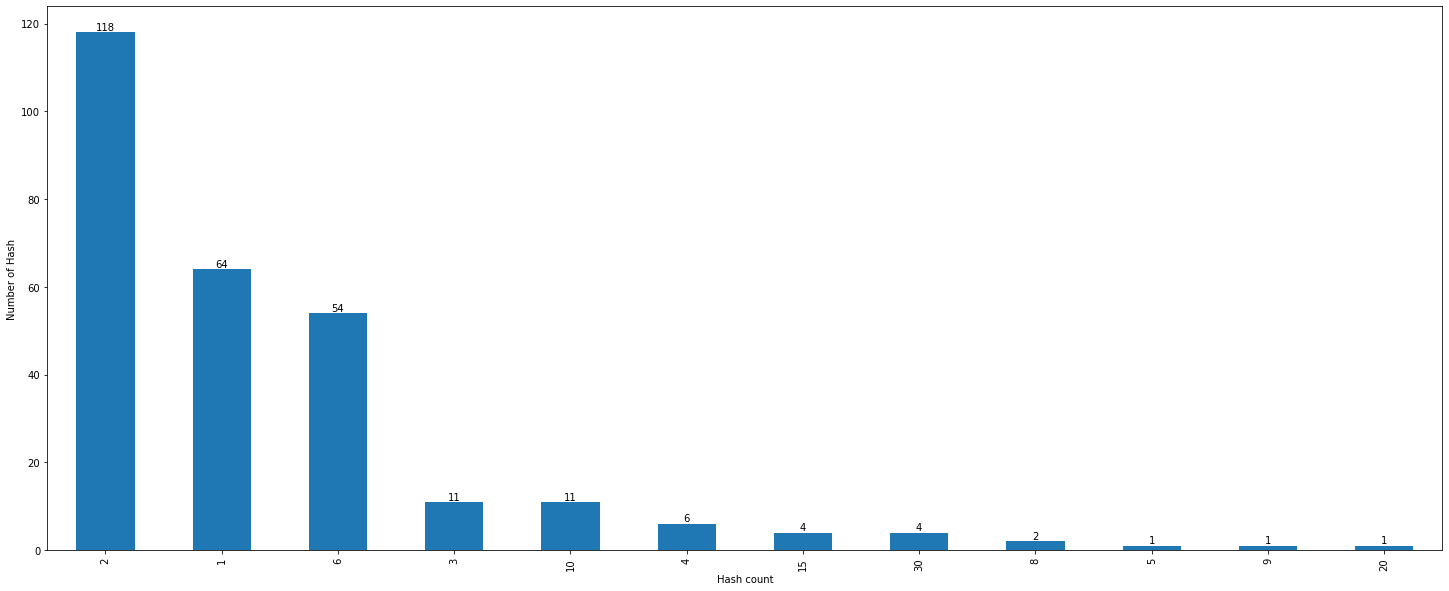

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# First, group the rows of the GeoDataFrame by hash_count and count the number of rows in each group
grouped = gdf.groupby('Hash_count')['Geo_Hash'].nunique()

# Next, sort the groups by their count in descending order
grouped = grouped.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(25, 10))
# Finally, create a bar chart of the results
grouped.plot(kind='bar')
plt.xlabel('Hash count')
plt.ylabel('Number of Hash')
# Add the value on top of each bar
for i, v in enumerate(grouped.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## Polygons Relationships (Overlaps)

### Build Data Frame for Overlap Relationship

In [11]:
# Function to check if two polygons intersect
def intersecting_polygons(row1, row2):
    return row1['Geo'].intersects(row2['Geo'])

# Update the column names
rel_gdf_columns = ['Hash_Geo1', 'Hash_Geo2', 'Area_Geo1', 'Area_Geo2', 'Dup_Geo1', 'Dup_Geo2', 'Overlap', 'Overlap_Area', 'Geo_Union', 'Union_Area', 'Area1_OutOf_Overlap', 'Area2_OutOf_Overlap', 'Pct_Area1_OutOf', 'Pct_Area1_Under', 'Pct_Area2_OutOf', 'Pct_Area2_Under']
rel_gdf = pd.DataFrame(columns=rel_gdf_columns)

for i, row1 in gdf[gdf['Hash_count'] == 1].iterrows(): #gdf without duplicates
    for j, row2 in gdf.iterrows():  #gdf without duplicates
        if i != j and intersecting_polygons(row1, row2):
            overlap = row1['Geo'].intersection(row2['Geo'])
            overlap_area = overlap.area
            geo_union = row1['Geo'].union(row2['Geo'])
            union_area = geo_union.area
            area1_out_of_overlap = row1['Area'] - overlap_area
            area2_out_of_overlap = row2['Area'] - overlap_area
            pct_area1_out_of = (area1_out_of_overlap / row1['Area']) * 100
            pct_area1_under = (overlap_area / row1['Area']) * 100
            pct_area2_out_of = (area2_out_of_overlap / row2['Area']) * 100
            pct_area2_under = (overlap_area / row2['Area']) * 100
            rel_gdf = rel_gdf.append({
                'Hash_Geo1': row1['Geo_Hash'],
                'Hash_Geo2': row2['Geo_Hash'],
                'Area_Geo1': row1['Area'],
                'Area_Geo2': row2['Area'],
                'Dup_Geo1': row1['Hash_count'],
                'Dup_Geo2': row2['Hash_count'],
                'Overlap': overlap,
                'Overlap_Area': overlap_area,
                'Geo_Union': geo_union,
                'Union_Area': union_area,
                'Area1_OutOf_Overlap': area1_out_of_overlap,
                'Area2_OutOf_Overlap': area2_out_of_overlap,
                'Pct_Area1_OutOf': pct_area1_out_of,
                'Pct_Area1_Under': pct_area1_under,
                'Pct_Area2_OutOf': pct_area2_out_of,
                'Pct_Area2_Under': pct_area2_under
            }, ignore_index=True)

print(len(rel_gdf))
rel_gdf = rel_gdf.drop_duplicates(subset=['Hash_Geo1', 'Hash_Geo2'])
rel_gdf.reset_index(drop=True, inplace=True)
print(len(rel_gdf))

79
59


In [12]:
rel_gdf.head()

,Hash_Geo1,Hash_Geo2,Area_Geo1,Area_Geo2,Dup_Geo1,Dup_Geo2,Overlap,Overlap_Area,Geo_Union,Union_Area,Area1_OutOf_Overlap,Area2_OutOf_Overlap,Pct_Area1_OutOf,Pct_Area1_Under,Pct_Area2_OutOf,Pct_Area2_Under
0,8881278119922995956,8010114144288444398,10535.488766,6598.706356,1,1,(POLYGON ((3441819.343333113 136093.9504783643...,335.537853,"POLYGON ((3441943.002435383 136176.7904187643,...",16798.657270,10199.950914,6263.168503,96.815166,3.184834,94.915096,5.084904
1,-5067784114806991945,3272770362448327490,5820.865280,6949.328762,1,2,"(POLYGON ((3441617.040617291 135577.808853562,...",36.423389,"POLYGON ((3441496.682348185 135468.8357357969,...",12733.770653,5784.441891,6912.905373,99.374262,0.625738,99.475872,0.524128
2,-6136445844668835706,3956525141400710144,6725.032614,6981.824395,1,1,"POLYGON ((3783777.272123834 110183.8392162165,...",6350.366886,"POLYGON ((3783776.031720091 110184.4220095614,...",7356.490123,374.665728,631.457509,5.571211,94.428789,9.044305,90.955695
3,-4527833179343275690,-2204234860644507040,59756.141944,6718.534829,1,1,"POLYGON ((3441195.360466163 144143.9775073509,...",9.842857,"POLYGON ((3441278.880351225 144140.090551589, ...",66464.833917,59746.299087,6708.691973,99.983528,0.016472,99.853497,0.146503
4,-6995673994357271993,779712506608541104,19079.678712,37095.082420,1,1,(POLYGON ((3436537.035510274 136884.6606448438...,17326.917028,"POLYGON ((3436668.892938221 136868.1079416372,...",38847.844104,1752.761684,19768.165392,9.186537,90.813463,53.290528,46.709472


### Drop same bilateral Overlap

In [13]:
# Sort the GeoDataFrame by Hash_Geo1 and Hash_Geo2
rel_gdf = rel_gdf.sort_values(['Overlap_Area'])
result=rel_gdf

# Create a new column that contains the concat of Hash_Geo1 and Hash_Geo2 for each row
result['Hash_Geo1_2'] = result.apply(lambda x: ''.join(sorted([str(x['Hash_Geo1']), str(x['Hash_Geo2'])])), axis=1)

# Create another new column that contains the concat of Hash_Geo2 and Hash_Geo1 for each row
result['Hash_Geo2_1'] = result.apply(lambda x: ''.join(sorted([str(x['Hash_Geo2']), str(x['Hash_Geo1'])])), axis=1)

# Identify the duplicate rows based on the conditions provided
duplicates = result[ (result['Overlap_Area'].duplicated(keep=False)) & 
                     (result['Hash_Geo1_2'] == result['Hash_Geo2_1'])]

# Drop the duplicate rows from the original GeoDataFrame
result = result.drop(duplicates.index)

print(len(rel_gdf),len(result), len(duplicates))
result.head()

59 51 8


,Hash_Geo1,Hash_Geo2,Area_Geo1,Area_Geo2,Dup_Geo1,Dup_Geo2,Overlap,Overlap_Area,Geo_Union,Union_Area,Area1_OutOf_Overlap,Area2_OutOf_Overlap,Pct_Area1_OutOf,Pct_Area1_Under,Pct_Area2_OutOf,Pct_Area2_Under,Hash_Geo1_2,Hash_Geo2_1
20,1372958058760671372,2136077557491414253,13724.453845,8858.000829,1,1,"POLYGON ((3437203.332256061 134167.9688166638,...",0.355407,"POLYGON ((3437017.857913005 134289.4269197531,...",22582.099267,13724.098438,8857.645422,99.997410,0.002590,99.995988,0.004012,13729580587606713722136077557491414253,13729580587606713722136077557491414253
48,2136077557491414253,1372958058760671372,8858.000829,13724.453845,1,1,"POLYGON ((3437201.840653227 134166.2480575006,...",0.355407,"POLYGON ((3437228.285682143 134114.7254327906,...",22582.099267,8857.645422,13724.098438,99.995988,0.004012,99.997410,0.002590,13729580587606713722136077557491414253,13729580587606713722136077557491414253
10,5646250897807993605,8447709528635600197,5.055691,159.809093,1,5,"POLYGON ((3490750.583154555 159073.842178163, ...",1.227213,"POLYGON ((3490751.002833117 159074.6410881792,...",163.637571,3.828478,158.581881,75.726116,24.273884,99.232076,0.767924,56462508978079936058447709528635600197,56462508978079936058447709528635600197
44,-3191978073174300809,1940780295796282813,12053.367877,6395.706216,1,1,"POLYGON ((3785711.760462905 117935.0568805854,...",5.222713,"POLYGON ((3785699.347030255 117931.7988750876,...",18443.851381,12048.145165,6390.483504,99.956670,0.043330,99.918340,0.081660,-31919780731743008091940780295796282813,-31919780731743008091940780295796282813
16,1940780295796282813,-3191978073174300809,6395.706216,12053.367877,1,1,"POLYGON ((3785702.032806503 117930.7415782318,...",5.222713,"POLYGON ((3785687.139790976 117927.8590688429,...",18443.851381,6390.483504,12048.145165,99.918340,0.081660,99.956670,0.043330,-31919780731743008091940780295796282813,-31919780731743008091940780295796282813


## New Joined GeoDataFrame with Aggregations

In [14]:
old_gdf=gdf
old_gdf.head()
# Create a DataFrame that contains the sum of Area1_OutOf_Overlap and Area2_OutOf_Overlap for each Geo_Hash
area1_df = rel_gdf.groupby('Hash_Geo1')['Area1_OutOf_Overlap'].sum().reset_index().rename(columns={'Hash_Geo1': 'Geo_Hash', 'Area1_OutOf_Overlap': 'Net_Area1'})
area2_df = rel_gdf.groupby('Hash_Geo2')['Area2_OutOf_Overlap'].sum().reset_index().rename(columns={'Hash_Geo2': 'Geo_Hash', 'Area2_OutOf_Overlap': 'Net_Area2'})

# Merge the sum of Net_Area1 and Net_Area2 into gdf
gdf = gdf.merge(area1_df, on='Geo_Hash', how='left')
gdf = gdf.merge(area2_df, on='Geo_Hash', how='left')

# Define a function to calculate the Net_Area
def calculate_net_area(row):
    if not pd.isna(row['Net_Area1']):
        return row['Net_Area1']
    elif not pd.isna(row['Net_Area2']):
        return row['Net_Area2']
    else:
        return row['Area']

gdf['Net_Area'] = gdf.apply(calculate_net_area, axis=1)
# Drop the Net_Area1 and Net_Area2 columns from the GeoDataFrame
gdf = gdf.drop(['Net_Area1', 'Net_Area2'], axis=1)
gdf['Net_Overlap'] = (gdf['Area'] - gdf['Net_Area'] )/2

In [15]:
gdf.head(10)

,Id,Type,Pair,Geo,Area,Geo_Hash,Hash_count,Net_Area,Net_Overlap
0,0,a,"POLYGON ((30.9195000615594 1.22320399310169, 3...","POLYGON ((3441943.002 136176.790, 3441943.590 ...",10535.488766,8881278119922995956,1,10199.950914,167.768926
1,1,a,"POLYGON ((30.9154907 1.2168457697, 30.91549089...","POLYGON ((3441496.682 135468.836, 3441496.704 ...",5820.865280,-5067784114806991945,1,5784.441891,18.211694
2,2,a,"POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((3531241.965 203899.007, 3531241.536 ...",10608.993490,4763584680579187363,2,10608.993490,0.000000
3,3,a,"POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((3529088.964 204636.044, 3529088.956 ...",6509.284802,7085646169197598312,2,6509.284802,0.000000
4,4,a,"POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((3529508.485 204726.185, 3529507.913 ...",5750.678495,-2972042165518026682,2,5750.678495,0.000000
5,5,a,"POLYGON ((31.1106548645825 1.40846818571946, 3...","POLYGON ((3463222.258 156805.755, 3463221.484 ...",21369.740032,2343209377923751519,6,21369.740032,0.000000
6,6,a,"POLYGON ((31.1106548645825 1.40846818571946, 3...","POLYGON ((3463222.258 156805.755, 3463221.484 ...",21369.740032,2343209377923751519,6,21369.740032,0.000000
7,7,a,"POLYGON ((31.1106548645825 1.40846818571946, 3...","POLYGON ((3463222.258 156805.755, 3463221.484 ...",21369.740032,2343209377923751519,6,21369.740032,0.000000
8,8,a,"POLYGON ((31.7252774618528 1.83009326642251, 3...","POLYGON ((3531641.732 203759.701, 3531641.658 ...",2337.226579,2481737331561509183,2,2337.226579,0.000000
9,9,a,"POLYGON ((31.7236659512954 1.83209310139824, 3...","POLYGON ((3531462.340 203982.435, 3531462.335 ...",2630.212549,8443556727833654083,6,2630.212549,0.000000


## Plot Key Metrics

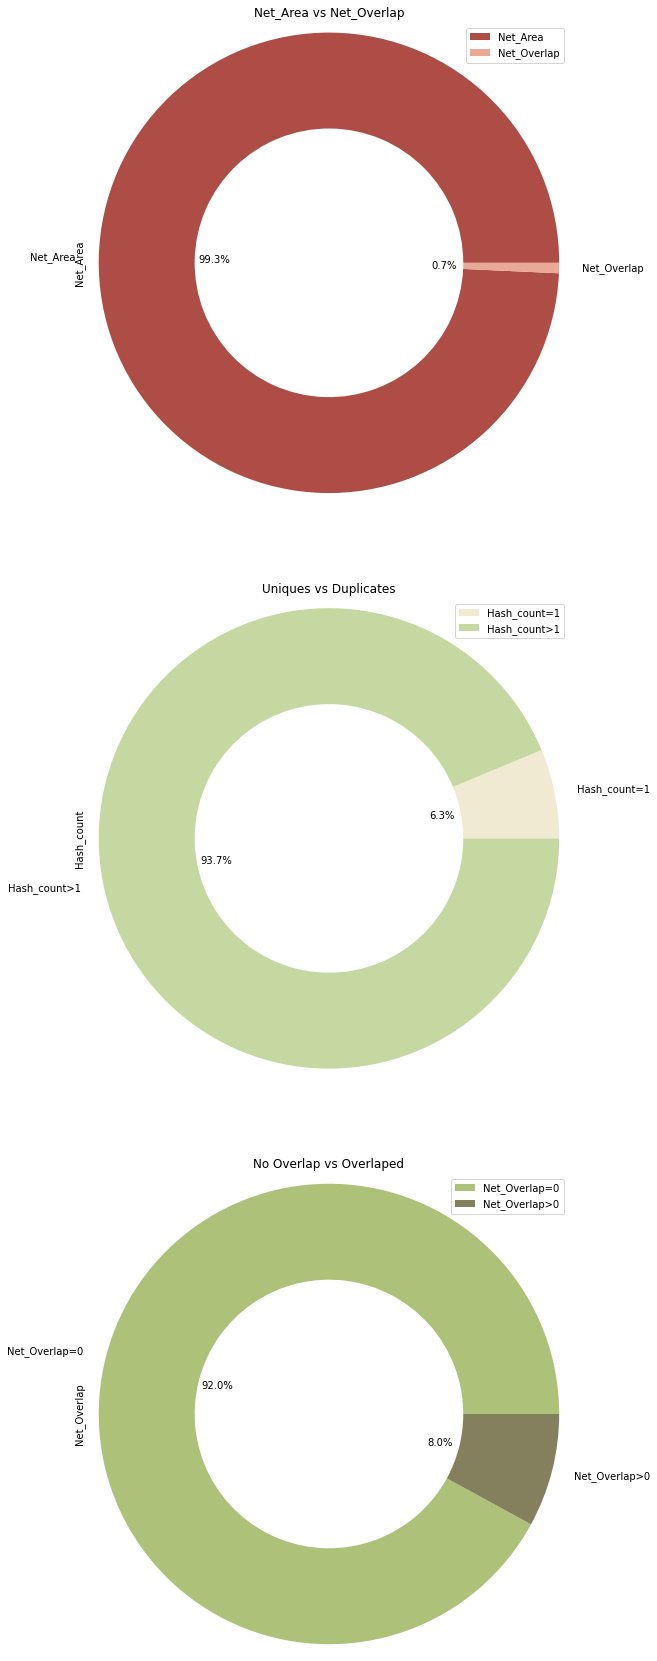

In [16]:
import matplotlib.pyplot as plt

# Create a dataframe for each donut chart
df1 = pd.DataFrame({'Net_Area': [gdf['Net_Area'].sum(), gdf['Net_Overlap'].sum()]},
                   index=['Net_Area', 'Net_Overlap'])
df2 = pd.DataFrame({'Hash_count': [len(gdf[gdf['Hash_count'] == 1]), len(gdf[gdf['Hash_count'] > 1])]},
                   index=['Hash_count=1', 'Hash_count>1'])
df3 = pd.DataFrame({'Net_Overlap': [len(gdf[gdf['Net_Overlap'] == 0]), len(gdf[gdf['Net_Overlap'] > 0])]},
                   index=['Net_Overlap=0', 'Net_Overlap>0'])

# Set the figure size and create subplots for each donut chart
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,30))

# Define the colors for each category
colors1 = ['#ad4d46', '#eaa897']
colors2 = ['#f0ead2', '#c5d8a1']
colors3 = ['#adc178', '#84805d']

# Plot the donut charts
df1.plot.pie(y='Net_Area', ax=ax1, colors=colors1, autopct='%1.1f%%', pctdistance=0.5, radius=1.2, wedgeprops=dict(width=0.5))
df2.plot.pie(y='Hash_count', ax=ax2, colors=colors2, autopct='%1.1f%%', pctdistance=0.5, radius=1.2, wedgeprops=dict(width=0.5))
df3.plot.pie(y='Net_Overlap', ax=ax3, colors=colors3, autopct='%1.1f%%', pctdistance=0.5, radius=1.2, wedgeprops=dict(width=0.5))

# Set titles for each subplot
ax1.set_title('Net_Area vs Net_Overlap')
ax2.set_title('Uniques vs Duplicates')
ax3.set_title('No Overlap vs Overlaped')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Show the donut charts
plt.show()


### Results in Summary

In [20]:
# Total Duplicates (count of Hash_count>1)
total_duplicates = gdf[gdf['Hash_count'] > 1]['Hash_count'].count()

# Total Uniques (count of Hash_count=1)
total_uniques = gdf[gdf['Hash_count'] == 1]['Hash_count'].count()

# Total Accurate (count of Net_Overlap=0 or NaN)
total_accurate = gdf[(gdf['Net_Overlap'] == 0) | gdf['Net_Overlap'].isna()]['Net_Overlap'].count()

# Total Overlapped (count of Net_Overlap>0)
total_overlapped = gdf[gdf['Net_Overlap'] > 0]['Net_Overlap'].count()

# Total Net Area (sum of Net_Area)
total_net_area = gdf['Net_Area'].sum()

# Total Net Overlap (sum of Net_Overlap)
total_net_overlap = gdf['Net_Overlap'].sum()

# % Area Under Overlap (sum of Net_Area compared with sum of Area)
pct_area_out_of_overlap  = (total_net_area / gdf['Area'].sum()) * 100

# % Area Out Of Overlap (sum of Net_Overlap compared with sum of Area)
pct_area_under_overlap = ((total_net_overlap*2) / gdf['Area'].sum()) * 100

# % Parcels Accurate (count of Net_Overlap=0 or NaN compared with count of rows)
pct_parcels_accurate = (total_accurate / len(gdf)) * 100

# Calculate the percentage of uniques
pct_uniques = (total_uniques / len(gdf)) * 100

# Calculate the percentage of duplicates
pct_duplicates = (total_duplicates / len(gdf)) * 100

print("Analysis Results:")
print("-----------------")
print(f"Total Duplicates: {total_duplicates}")
print(f"Total Uniques: {total_uniques}")
print(f"Total Accurate: {total_accurate}")
print(f"Total Overlapped: {total_overlapped}")
print(f"Total Net Area: {total_net_area}")
print(f"Total Net Overlap: {total_net_overlap}")
print(f"% Area Under Overlap: {pct_area_under_overlap:.2f}%")
print(f"% Area Out Of Overlap: {pct_area_out_of_overlap:.2f}%")
print(f"% Parcels Accurate: {pct_parcels_accurate:.2f}%")
print(f"% Uniques Parcels: {pct_uniques:.2f}%")
print(f"% Duplicate Parcels: {pct_duplicates:.2f}%")


Analysis Results:
-----------------
Total Duplicates: 957
Total Uniques: 64
Total Accurate: 937
Total Overlapped: 81
Total Net Area: 8361840.764918392
Total Net Overlap: 60887.95847760732
% Area Under Overlap: 1.44%
% Area Out Of Overlap: 98.56%
% Parcels Accurate: 91.77%
% Uniques Parcels: 6.27%
% Duplicate Parcels: 93.73%


### Export DataFrames to CSV

In [25]:
# Export dataframe to a CSV file
##main_url = '/Users/mmadriz/Downloads/taking-root-da-hw-main/data/'
main_url = 'https://raw.githubusercontent.com/farm-trace/taking-root-da-hw/main/data/'
export_relation = main_url + 'geog_rel.csv'
export_main_gdf = main_url + 'main_gdf.csv'
gdf.to_csv(export_relation, index=False)
gdf.to_csv(export_main_gdf, index=False)
print('Export complete.')

Export complete.
